# Konuşma Metinlerinden Duygu Analizi (NLP + Sentiment)

**Veri Seti:** Sentiment140 Twitter Data  
**Senaryo:** Tweet metinlerinden duygu analizleri çıkarılır.  
**Kullanılan Teknikler:** TF-IDF + Lojistik Regresyon, LSTM, BERT, FastText  
**Değer:** Marka analizi, müşteri memnuniyeti

Bu projede farklı NLP yöntemleriyle Tweet'lerden duygu analizleri gerçekleştireceğiz.

In [6]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras jupyter ipykernel transformers fasttext-wheel

  Using cached pandas-2.3.0-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.2-cp311-cp311-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp311-cp311-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached scipy-1.15.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Temel NLP
import re
import string

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


## 2. Veri Yükleme & İlk Bakış

Sentiment140 veri setini Kaggle'dan indirip, ilgili CSV dosyasını yüklüyoruz.  
Veri setinin ilk birkaç satırına göz atacağız.

In [8]:
# Örnek dosya adı: training.1600000.processed.noemoticon.csv
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df = df[["target", "text"]]

df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## 3. Veri Temizliği & Ön İşleme

Tweet metinlerinde gereksiz karakterleri, URL'leri, mentionları ve noktalama işaretlerini temizliyoruz.

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)   # URL sil
    text = re.sub(r"@\w+", "", text)              # Mention sil
    text = re.sub(r"#\w+", "", text)              # Hashtag sil
    text = re.sub(r"[^\w\s]", "", text)           # Noktalama işaretleri sil
    text = re.sub(r"\d+", "", text)               # Sayılar sil
    text = text.strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['target'] = df['target'].map({0:0, 4:1})   # 0: Negatif, 4: Pozitif

df.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


## 4. Veri Kümesini Hazırla (Train/Test)

Veri setini eğitim ve test olarak bölüyoruz.

In [10]:
X = df['clean_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. TF-IDF + Lojistik Regresyon

TF-IDF ile metinleri vektörleştirip, Lojistik Regresyon modeli ile duygu analizi gerçekleştiriyoruz.

In [11]:
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.79413125
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



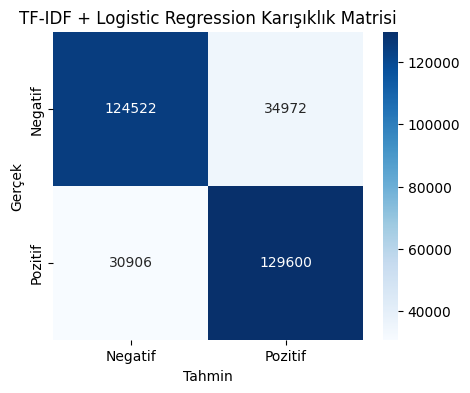

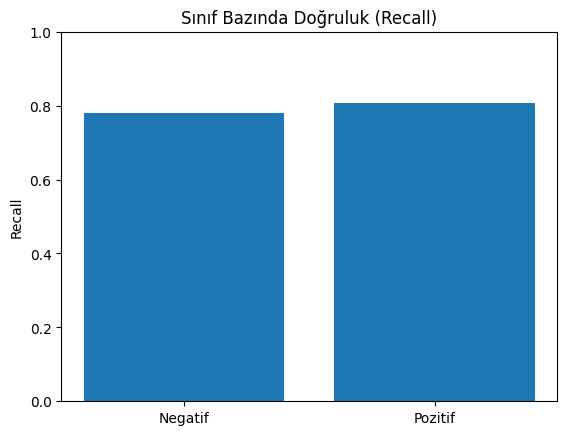

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatif", "Pozitif"], yticklabels=["Negatif", "Pozitif"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("TF-IDF + Logistic Regression Karışıklık Matrisi")
plt.show()

# Sınıf Bazında Recall
report = classification_report(y_test, y_pred, output_dict=True)
class_labels = ["Negatif", "Pozitif"]
recall_scores = [report['0']['recall'], report['1']['recall']]
plt.bar(class_labels, recall_scores)
plt.ylim(0, 1)
plt.title("Sınıf Bazında Doğruluk (Recall)")
plt.ylabel("Recall")
plt.show()

## 6. LSTM ile Duygu Analizi

Deep learning yöntemi olarak LSTM (Long Short-Term Memory) kullanarak duygu analizini deneyelim.

In [12]:
# Parametreler
max_words = 10000
max_len = 40

# Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train, epochs=2, batch_size=1024, validation_split=0.1)

y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


Epoch 1/2


D:\projects\tf_env311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 144s 127ms/step - accuracy: 0.7648 - loss: 0.4837 - val_accuracy: 0.8095 - val_loss: 0.4147
Epoch 2/2
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.8135 - loss: 0.4066 - val_accuracy: 0.8155 - val_loss: 0.4036
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Accuracy: 0.8156375
              precision    recall  f1-score   support

           0       0.81      0.82      0.82    159494
           1       0.82      0.81      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



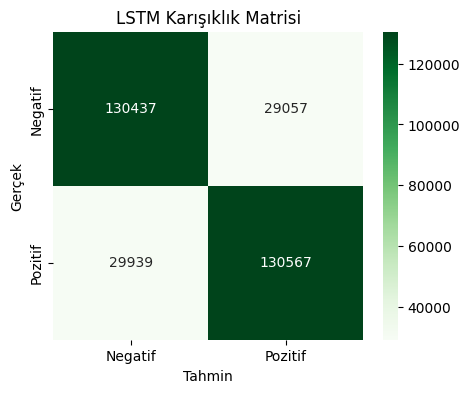

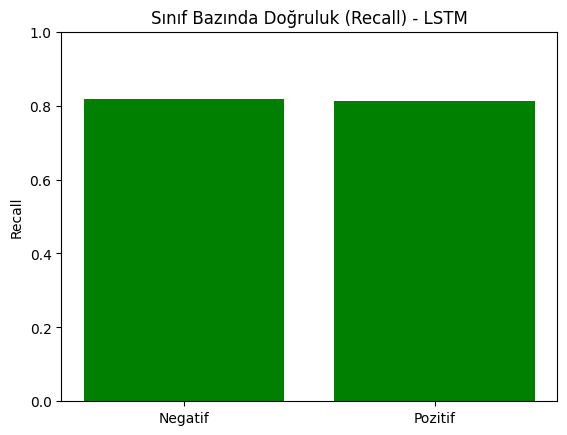

In [21]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Greens", xticklabels=["Negatif", "Pozitif"], yticklabels=["Negatif", "Pozitif"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("LSTM Karışıklık Matrisi")
plt.show()

report_lstm = classification_report(y_test, y_pred_lstm, output_dict=True)
class_labels = ["Negatif", "Pozitif"]
recall_scores = [report_lstm['0']['recall'], report_lstm['1']['recall']]
plt.bar(class_labels, recall_scores, color='green')
plt.ylim(0, 1)
plt.title("Sınıf Bazında Doğruluk (Recall) - LSTM")
plt.ylabel("Recall")
plt.show()

## 7. BERT ile Duygu Analizi

BERT tabanlı bir modelle duygu analizi gerçekleştirelim.

In [14]:
!pip install tf-keras


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 31.2 MB/s eta 0:00:00


In [16]:
# Huggingface Transformers ile BERT modeli
from transformers import BertTokenizer, TFBertForSequenceClassification
import tf_keras as keras   # tf-keras kullandık!
from sklearn.metrics import accuracy_score, classification_report

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(texts, tokenizer, max_len=40):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

X_train_bert, X_train_mask = bert_encode(X_train[:5000], bert_tokenizer, max_len=40)
X_test_bert, X_test_mask = bert_encode(X_test[:1000], bert_tokenizer, max_len=40)

model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_bert.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

model_bert.fit([X_train_bert, X_train_mask], y_train[:5000], epochs=2, batch_size=16, validation_split=0.1)

y_pred_bert = np.argmax(model_bert.predict([X_test_bert, X_test_mask]).logits, axis=1)
print("Accuracy:", accuracy_score(y_test[:1000], y_pred_bert))
print(classification_report(y_test[:1000], y_pred_bert))


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


282/282 [==============================] - 493s 2s/step - loss: 0.5181 - accuracy: 0.7373 - val_loss: 0.4176 - val_accuracy: 0.7860
Epoch 2/2
32/32 [==============================] - 28s 807ms/step
Accuracy: 0.828
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       496
           1       0.85      0.80      0.82       504

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



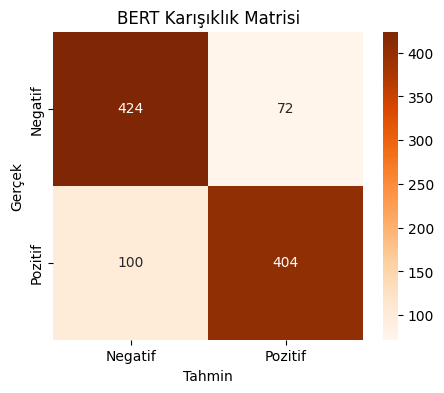

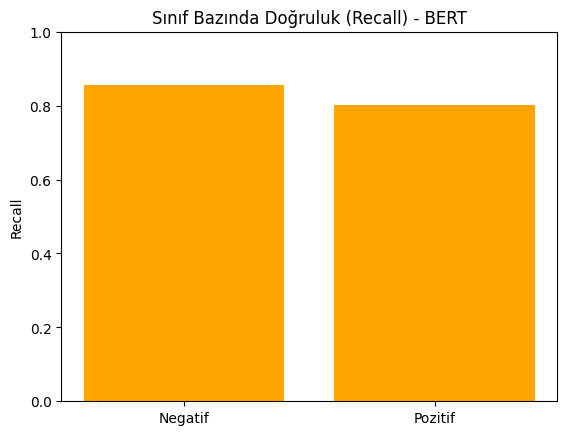

In [22]:
cm_bert = confusion_matrix(y_test[:1000], y_pred_bert)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negatif", "Pozitif"], yticklabels=["Negatif", "Pozitif"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("BERT Karışıklık Matrisi")
plt.show()

report_bert = classification_report(y_test[:1000], y_pred_bert, output_dict=True)
class_labels = ["Negatif", "Pozitif"]
recall_scores = [report_bert['0']['recall'], report_bert['1']['recall']]
plt.bar(class_labels, recall_scores, color='orange')
plt.ylim(0, 1)
plt.title("Sınıf Bazında Doğruluk (Recall) - BERT")
plt.ylabel("Recall")
plt.show()


## 8. FastText ile Duygu Analizi

FastText ile hızlı ve etkili bir duygu analizi uygulaması.

In [17]:
import fasttext

# FastText için veri hazırlama (etiket formatı: __label__pozitif)
def write_fasttext_file(X, y, fname):
    with open(fname, "w", encoding="utf-8") as f:
        for text, label in zip(X, y):
            f.write(f"__label__{label} {text}\n")

write_fasttext_file(X_train, y_train, "ft_train.txt")
write_fasttext_file(X_test, y_test, "ft_test.txt")

model_ft = fasttext.train_supervised('ft_train.txt', epoch=5, lr=1.0, wordNgrams=2)
result = model_ft.test('ft_test.txt')

print(f"FastText Accuracy: {result[1]}")

FastText Accuracy: 0.81364375


## 9. Sonuç & Yorumlar

- Farklı tekniklerle duygu analizini karşılaştırdık.
- Marka ve müşteri analizinde hangi yöntemin daha iyi çalıştığını gözlemleyebilirsiniz.
- LSTM ve BERT gibi derin öğrenme tabanlı yöntemler genellikle daha iyi sonuçlar verir, fakat eğitim süreleri daha uzundur.